# **Optimization of Maximum Food Supply to Impoverished Countries with Cost-efficiency**

**Group Members:**

*   Soptorsi Paul Shrestha
*   Lamiya Sadaf
*   Sadiah Karim






In [1]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 66.6 MB/s eta 0:00:00


**General Optimization**

In [13]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices
M = [1, 2, 3, 4, 5]  # Example list of countries below the poverty line
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes

# Generate random parameters using NumPy arrays
FR = np.array([1400000,  2000000,  7800000, 25800000,  6600000])   # Annual food requirements for country i
DA = np.array([20000000,  20000000,  30000000, 500000000,  70000000])  # Annual donation to WFP for country i
PD = np.array([6, 7, 6, 6, 9])   # Preservation period for food in country i
SC = np.array([140000000,  200000000,  780000000, 2580000000,  660000000])  # Storage capacity of the local hub for country i
MC = np.random.randint(50000, 200000, size=len(N))  # Maximum capacity for transportation mode j
#CT = {(i, j): {'Truck': 100, 'Ship': 200, 'Airline': 300}[j] for i in M for j in N}






# Additional data about countries
country_data = {
    'Burundi': {'Food Demand': 1400000, 'Road Network Extent (km)': 12232, 'Water Network Extent (km)': 673, 'Airports': 2},
    'Central African Republic': {'Food Demand': 2000000, 'Road Network Extent (km)': 23810, 'Water Network Extent (km)': 900, 'Airports': 3},
    'South Sudan': {'Food Demand': 7800000, 'Road Network Extent (km)': 90200, 'Water Network Extent (km)': 1400, 'Airports': 3},
    'Congo': {'Food Demand': 25800000, 'Road Network Extent (km)': 171250, 'Water Network Extent (km)': 16238, 'Airports': 60},
    'Somalia': {'Food Demand': 6600000, 'Road Network Extent (km)': 21830, 'Water Network Extent (km)': 3000, 'Airports': 62}
}


# Extracting the relevant data
food_demand = {country: country_data[country]['Food Demand'] for country in country_data}
road_network_extent = {country: country_data[country]['Road Network Extent (km)'] for country in country_data}
water_network_extent = {country: country_data[country]['Water Network Extent (km)'] for country in country_data}
airports = {country: country_data[country]['Airports'] for country in country_data}



# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039,
 (2, 'Truck'): 0.085,
 (2, 'Ship'): 0.047,
 (2, 'Airline'): 0.031,
 (3, 'Truck'): 0.078,
 (3, 'Ship'): 0.069,
 (3, 'Airline'): 0.037,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j



# Constraints
PC = random.randint(500000000000, 1000000000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 700000, 'Ship': 7800000, 'Airline': 78000},
    2: {'Truck': 600000, 'Ship': 8000000, 'Airline': 88000},
    3: {'Truck': 500000, 'Ship': 8200000, 'Airline': 98000},
    4: {'Truck': 400000, 'Ship': 9000000, 'Airline': 58000},
    5: {'Truck': 300000, 'Ship': 8500000, 'Airline': 68000},
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")






distances = {(1, 'Truck'): 120, (1, 'Ship'): 60, (1, 'Airline'): 30,
             (2, 'Truck'): 230, (2, 'Ship'): 90, (2, 'Airline'): 30,
             (3, 'Truck'): 900, (3, 'Ship'): 300, (3, 'Airline'): 200,
             (4, 'Truck'): 170, (4, 'Ship'): 150, (4, 'Airline'): 100,
             (5, 'Truck'): 210, (5, 'Ship'): 150, (5, 'Airline'): 20}


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.2, 'Summer': 0.0, 'Rainy Season': 0.1}
weather_time_multiplier = {'Winter': 0.3, 'Summer': 0.0, 'Rainy Season': 0.15}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.15, 'Poor': 0.3}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.1, 'Poor': 0.25}

# Define the weight factors
alpha = 1
beta = 1
gamma = 1
delta = 1

# Objective Function
model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -
    beta * gp.quicksum((weather_cost_multiplier[weather_condition]
                        + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                       for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
    gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                         + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                        for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
    delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
    sense=GRB.MAXIMIZE
)


# Objective Function
model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -
    beta * gp.quicksum((weather_cost_multiplier[weather_condition] + transportation_medium_cost_multiplier[transport_condition])
                  * CT[i, j] * Q[i, j] for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
    gamma * gp.quicksum(TT[i, j] * Q[i, j] for i in M for j in N),
    sense=GRB.MAXIMIZE
)


# Solve the optimization problem
model.optimize()

# Retrieve the optimal solution
optimal_solution = {(i, j): Q[i, j].x for i in M for j in N}

# Display optimized values
for i in M:
    for j in N:
        print(f"Q_{i}_{j}: {optimal_solution[i, j]}")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0xf2b172e6
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 79 rows and 2 columns
Presolve time: 0.01s
Presolved: 5 rows, 13 columns, 17 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7282181e+05   6.250000e-01   0.000000e+00      0s
       4    1.7281981e+05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.728198078e+05
Q_1_Truck: 0.0
Q_1_Ship: 1.0
Q_1_Ai

**General Optimization Plot**

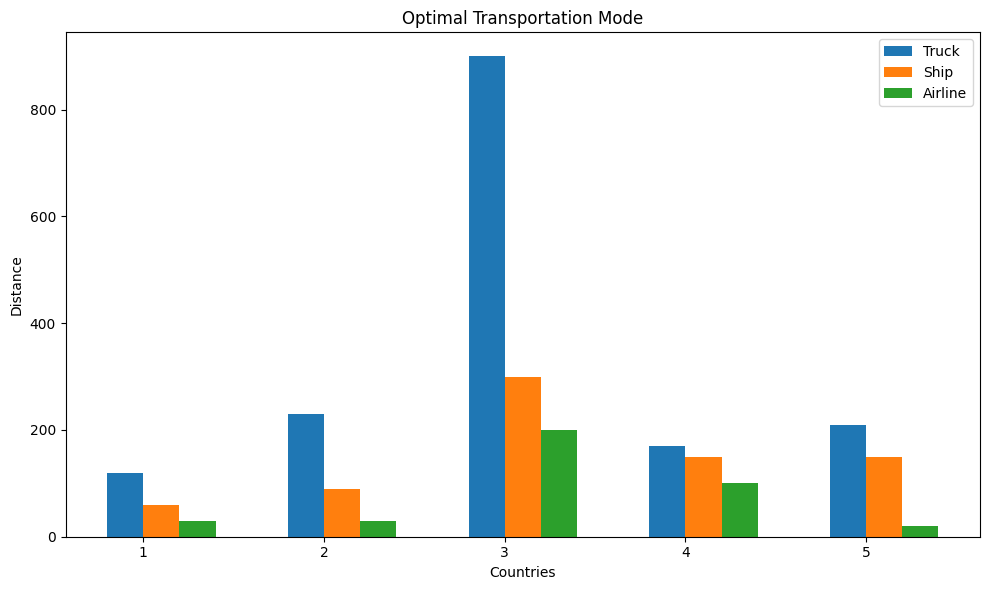

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom color palette
custom_palette = ['#FF6347', '#4682B4', '#32CD32']  # Example colors, you can modify or add more





# Extract data for visualization
countries = [1, 2, 3, 4, 5]
transport_modes = ['Truck', 'Ship', 'Airline']
dist_data = {
    mode: [distances[(country, mode)] for country in countries] for mode in transport_modes
}

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
for i, mode in enumerate(transport_modes):
    x_values = [country + i * bar_width for country in countries]
    plt.bar(x_values, dist_data[mode], width=bar_width, label=mode)

plt.xlabel('Countries')
plt.ylabel('Distance')
plt.title('Optimal Transportation Mode')
plt.xticks([country + 0.5 * bar_width for country in countries], countries)
plt.legend()
plt.tight_layout()
plt.show()

**Scenario 1 (Prioritizing Beta)**

In [3]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices

country_name = ['Burundi','Central African Republic','South Sudan','Congo','Somalia']

M = list(range(1, len(country_name) + 1))
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes


distances = {(1, 'Truck'): 120, (1, 'Ship'): 60, (1, 'Airline'): 30,
             (2, 'Truck'): 230, (2, 'Ship'): 90, (2, 'Airline'): 30,
             (3, 'Truck'): 900, (3, 'Ship'): 300, (3, 'Airline'): 200,
             (4, 'Truck'): 170, (4, 'Ship'): 150, (4, 'Airline'): 100,
             (5, 'Truck'): 210, (5, 'Ship'): 150, (5, 'Airline'): 20}
FR = np.array([1400000,  2000000,  7800000, 25800000,  6600000])   # Annual food requirements for country i
DA = np.array([20000000,  20000000,  30000000, 500000000,  70000000])  # Annual donation to WFP for country i
PD = np.array([6, 7, 6, 6, 9])   # Preservation period for food in country i
SC = np.array([140000000,  200000000,  780000000, 2580000000,  660000000])  # Storage capacity of the local hub for country i
#MC = np.array([1755080000,  796590000,  514140000])  # Maximum capacity for transportation mode j


# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039,
 (2, 'Truck'): 0.085,
 (2, 'Ship'): 0.047,
 (2, 'Airline'): 0.031,
 (3, 'Truck'): 0.078,
 (3, 'Ship'): 0.069,
 (3, 'Airline'): 0.037,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j

# Define the weight factors
alpha = 2
beta = 1.5
gamma = 0.1
delta = 0.1


# Objective Function
'''model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -  # Focus on total quantity distributed
    beta * gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) -  # Transportation cost
    gamma * gp.quicksum(TT[i, j] * Q[i, j] for i in M for j in N) +  # Transportation time cost
    delta * gp.quicksum(gp.quicksum(Q[i, j] for i in M) / MC[N.index(j)] for j in N),  # Constraint on maximum capacity
    sense=GRB.MAXIMIZE
)'''




# Constraints
PC = random.randint(500000000000, 1000000000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 700000, 'Ship': 7800000, 'Airline': 78000},
    2: {'Truck': 600000, 'Ship': 7800000, 'Airline': 88000},
    3: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000},
    4: {'Truck': 400000, 'Ship': 7800000, 'Airline': 58000},
    5: {'Truck': 300000, 'Ship': 7800000, 'Airline': 68000},
    6: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000}
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.0002, 'Summer': 0.0, 'Rainy Season': 0.0001}
weather_time_multiplier = {'Winter': 0.0003, 'Summer': 0.0, 'Rainy Season': 0.00015}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.00015, 'Poor': 0.0003}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.0001, 'Poor': 0.00025}

# Lists to store solutions
alpha_values = []
beta_values = []
objective_values = []

# Iterate through alpha and beta values
for alpha_value in np.linspace(0.1, 1.0, 5):
    for beta_value in np.linspace(0.1, 1.0, 5):
        # Set new objective function with adjusted weights
        model.setObjective(
            alpha_value * gp.quicksum(Q[i, j] for i in M for j in N) -
            beta_value * gp.quicksum((weather_cost_multiplier[weather_condition]
                                      + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                                     for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
            gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                                 + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                                for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
            delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
            sense=GRB.MAXIMIZE
        )

        # Optimize the model
        model.optimize()

        # Append values to lists
        alpha_values.append(alpha_value)
        beta_values.append(beta_value)
        objective_values.append(model.objVal)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0xf33e7b80
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 76 rows and 0 columns
Presolve time: 0.03s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.000000e+00   0.000000e+00      0s
       7   -4.7501690e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.05 seconds (0.00 work units)
Optimal objective -4.750168959e+01
Gurobi Optimizer version 11.0.0 bui

**Scenario 1 Plot**

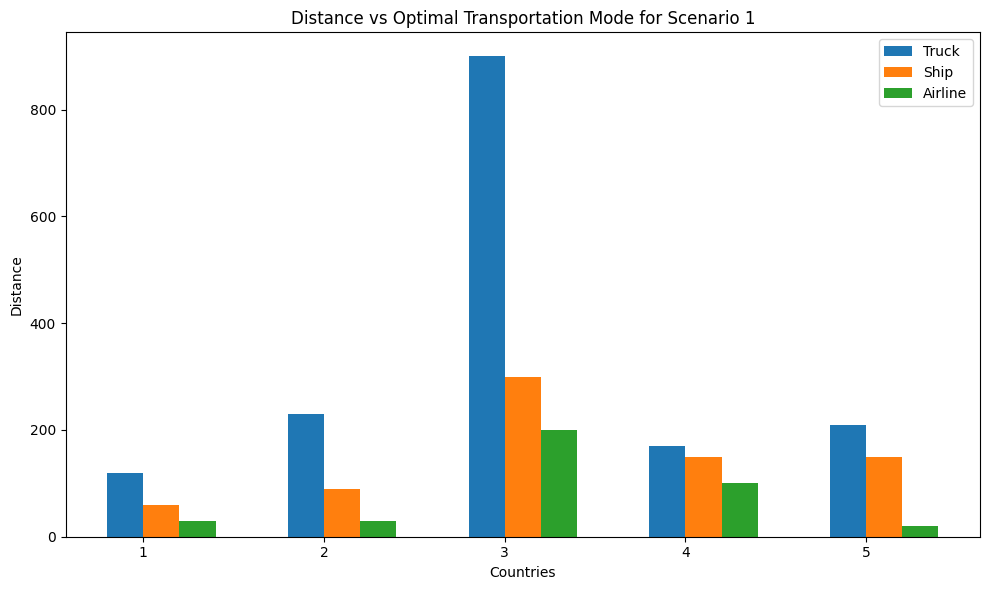

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom color palette
custom_palette = ['#FF6347', '#4682B4', '#32CD32']  # Example colors, you can modify or add more





# Extract data for visualization
countries = [1, 2, 3, 4, 5]
transport_modes = ['Truck', 'Ship', 'Airline']
dist_data = {
    mode: [distances[(country, mode)] for country in countries] for mode in transport_modes
}

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
for i, mode in enumerate(transport_modes):
    x_values = [country + i * bar_width for country in countries]
    plt.bar(x_values, dist_data[mode], width=bar_width, label=mode)

plt.xlabel('Countries')
plt.ylabel('Distance')
plt.title('Distance vs Optimal Transportation Mode for Scenario 1')
plt.xticks([country + 0.5 * bar_width for country in countries], countries)
plt.legend()
plt.tight_layout()
plt.show()

**Scenario 2 (Prioritizing Gamma)**

In [6]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices

country_name = ['Burundi','Central African Republic','South Sudan','Congo','Somalia']

M = list(range(1, len(country_name) + 1))
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes


distances = {(1, 'Truck'): 120, (1, 'Ship'): 60, (1, 'Airline'): 30,
             (2, 'Truck'): 230, (2, 'Ship'): 90, (2, 'Airline'): 30,
             (3, 'Truck'): 900, (3, 'Ship'): 300, (3, 'Airline'): 200,
             (4, 'Truck'): 170, (4, 'Ship'): 150, (4, 'Airline'): 100,
             (5, 'Truck'): 210, (5, 'Ship'): 150, (5, 'Airline'): 20}
FR = np.array([1400000,  2000000,  7800000, 25800000,  6600000])   # Annual food requirements for country i
DA = np.array([20000000,  20000000,  30000000, 500000000,  70000000])  # Annual donation to WFP for country i
PD = np.array([6, 7, 6, 6, 9])   # Preservation period for food in country i
SC = np.array([140000000,  200000000,  780000000, 2580000000,  660000000])  # Storage capacity of the local hub for country i
#MC = np.array([1755080000,  796590000,  514140000])  # Maximum capacity for transportation mode j


# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039,
 (2, 'Truck'): 0.085,
 (2, 'Ship'): 0.047,
 (2, 'Airline'): 0.031,
 (3, 'Truck'): 0.078,
 (3, 'Ship'): 0.069,
 (3, 'Airline'): 0.037,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j

# Define the weight factors
alpha = 2
beta = 0.1
gamma = 1.5
delta = 0.1


# Objective Function
'''model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -  # Focus on total quantity distributed
    beta * gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) -  # Transportation cost
    gamma * gp.quicksum(TT[i, j] * Q[i, j] for i in M for j in N) +  # Transportation time cost
    delta * gp.quicksum(gp.quicksum(Q[i, j] for i in M) / MC[N.index(j)] for j in N),  # Constraint on maximum capacity
    sense=GRB.MAXIMIZE
)'''




# Constraints
PC = random.randint(500000000000, 1000000000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 700000, 'Ship': 7800000, 'Airline': 78000},
    2: {'Truck': 600000, 'Ship': 7800000, 'Airline': 88000},
    3: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000},
    4: {'Truck': 400000, 'Ship': 7800000, 'Airline': 58000},
    5: {'Truck': 300000, 'Ship': 7800000, 'Airline': 68000},
    6: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000}
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.0002, 'Summer': 0.0, 'Rainy Season': 0.0001}
weather_time_multiplier = {'Winter': 0.0003, 'Summer': 0.0, 'Rainy Season': 0.00015}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.00015, 'Poor': 0.0003}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.0001, 'Poor': 0.00025}

# Lists to store solutions
alpha_values = []
beta_values = []
objective_values = []

# Iterate through alpha and beta values
for alpha_value in np.linspace(0.1, 1.0, 5):
    for beta_value in np.linspace(0.1, 1.0, 5):
        # Set new objective function with adjusted weights
        model.setObjective(
            alpha_value * gp.quicksum(Q[i, j] for i in M for j in N) -
            beta_value * gp.quicksum((weather_cost_multiplier[weather_condition]
                                      + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                                     for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
            gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                                 + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                                for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
            delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
            sense=GRB.MAXIMIZE
        )

        # Optimize the model
        model.optimize()

        # Append values to lists
        alpha_values.append(alpha_value)
        beta_values.append(beta_value)
        objective_values.append(model.objVal)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0xa29ebe13
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 76 rows and 0 columns
Presolve time: 0.02s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.000000e+00   0.000000e+00      0s
       7   -4.7513315e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective -4.751331458e+01
Gurobi Optimizer version 11.0.0 bui

**Scenario 2 Plot**

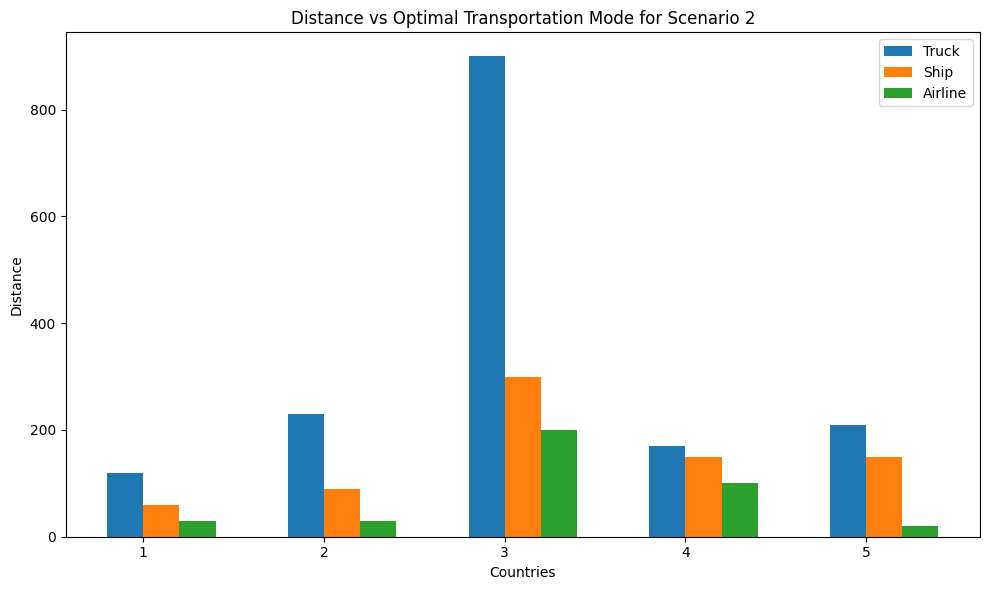

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom color palette
custom_palette = ['#FF6347', '#4682B4', '#32CD32']  # Example colors, you can modify or add more





# Extract data for visualization
countries = [1, 2, 3, 4, 5]
transport_modes = ['Truck', 'Ship', 'Airline']
dist_data = {
    mode: [distances[(country, mode)] for country in countries] for mode in transport_modes
}

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
for i, mode in enumerate(transport_modes):
    x_values = [country + i * bar_width for country in countries]
    plt.bar(x_values, dist_data[mode], width=bar_width, label=mode)

plt.xlabel('Countries')
plt.ylabel('Distance')
plt.title('Distance vs Optimal Transportation Mode for Scenario 2')
plt.xticks([country + 0.5 * bar_width for country in countries], countries)
plt.legend()
plt.tight_layout()
plt.show()

**Scenario 3 (Prioritizing Delta)**

In [8]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices

country_name = ['Burundi','Central African Republic','South Sudan','Congo','Somalia']

M = list(range(1, len(country_name) + 1))
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes


distances = {(1, 'Truck'): 120, (1, 'Ship'): 60, (1, 'Airline'): 30,
             (2, 'Truck'): 230, (2, 'Ship'): 90, (2, 'Airline'): 30,
             (3, 'Truck'): 900, (3, 'Ship'): 300, (3, 'Airline'): 200,
             (4, 'Truck'): 170, (4, 'Ship'): 150, (4, 'Airline'): 100,
             (5, 'Truck'): 210, (5, 'Ship'): 150, (5, 'Airline'): 20}
FR = np.array([1400000,  2000000,  7800000, 25800000,  6600000])   # Annual food requirements for country i
DA = np.array([20000000,  20000000,  30000000, 500000000,  70000000])  # Annual donation to WFP for country i
PD = np.array([6, 7, 6, 6, 9])   # Preservation period for food in country i
SC = np.array([140000000,  200000000,  780000000, 2580000000,  660000000])  # Storage capacity of the local hub for country i
#MC = np.array([1755080000,  796590000,  514140000])  # Maximum capacity for transportation mode j


# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039,
 (2, 'Truck'): 0.085,
 (2, 'Ship'): 0.047,
 (2, 'Airline'): 0.031,
 (3, 'Truck'): 0.078,
 (3, 'Ship'): 0.069,
 (3, 'Airline'): 0.037,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j

# Define the weight factors
alpha = 2.0
beta = 0.1
gamma = 0.1
delta = 1.5


# Objective Function
'''model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -  # Focus on total quantity distributed
    beta * gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) -  # Transportation cost
    gamma * gp.quicksum(TT[i, j] * Q[i, j] for i in M for j in N) +  # Transportation time cost
    delta * gp.quicksum(gp.quicksum(Q[i, j] for i in M) / MC[N.index(j)] for j in N),  # Constraint on maximum capacity
    sense=GRB.MAXIMIZE
)'''




# Constraints
PC = random.randint(500000000000, 1000000000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 700000, 'Ship': 7800000, 'Airline': 78000},
    2: {'Truck': 600000, 'Ship': 7800000, 'Airline': 88000},
    3: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000},
    4: {'Truck': 400000, 'Ship': 7800000, 'Airline': 58000},
    5: {'Truck': 300000, 'Ship': 7800000, 'Airline': 68000},
    6: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000}
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.0002, 'Summer': 0.0, 'Rainy Season': 0.0001}
weather_time_multiplier = {'Winter': 0.0003, 'Summer': 0.0, 'Rainy Season': 0.00015}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.00015, 'Poor': 0.0003}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.0001, 'Poor': 0.00025}

# Lists to store solutions
alpha_values = []
beta_values = []
objective_values = []

# Iterate through alpha and beta values
for alpha_value in np.linspace(0.1, 1.0, 5):
    for beta_value in np.linspace(0.1, 1.0, 5):
        # Set new objective function with adjusted weights
        model.setObjective(
            alpha_value * gp.quicksum(Q[i, j] for i in M for j in N) -
            beta_value * gp.quicksum((weather_cost_multiplier[weather_condition]
                                      + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                                     for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
            gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                                 + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                                for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
            delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
            sense=GRB.MAXIMIZE
        )

        # Optimize the model
        model.optimize()

        # Append values to lists
        alpha_values.append(alpha_value)
        beta_values.append(beta_value)
        objective_values.append(model.objVal)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0x835e9272
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [3e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 76 rows and 0 columns
Presolve time: 0.01s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.000000e+00   0.000000e+00      0s
       7   -7.1950129e+02   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective -7.195012858e+02
Gurobi Optimizer version 11.0.0 bui

**Scenario 3 Plot**

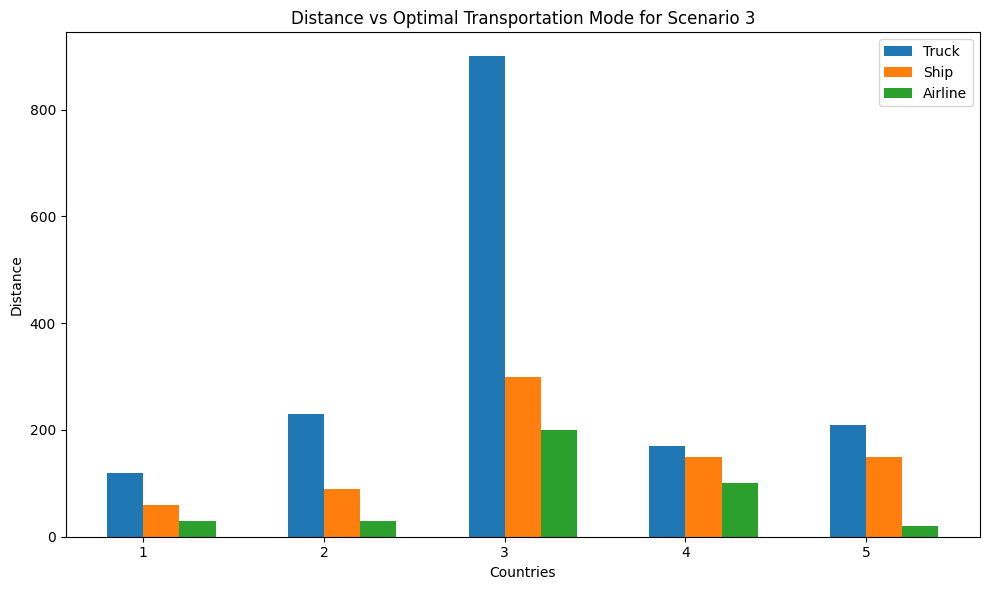

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom color palette
custom_palette = ['#FF6347', '#4682B4', '#32CD32']  # Example colors, you can modify or add more





# Extract data for visualization
countries = [1, 2, 3, 4, 5]
transport_modes = ['Truck', 'Ship', 'Airline']
dist_data = {
    mode: [distances[(country, mode)] for country in countries] for mode in transport_modes
}

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
for i, mode in enumerate(transport_modes):
    x_values = [country + i * bar_width for country in countries]
    plt.bar(x_values, dist_data[mode], width=bar_width, label=mode)

plt.xlabel('Countries')
plt.ylabel('Distance')
plt.title('Distance vs Optimal Transportation Mode for Scenario 3')
plt.xticks([country + 0.5 * bar_width for country in countries], countries)
plt.legend()
plt.tight_layout()
plt.show()

**Pareto optimal**

In [16]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices

country_name = ['Burundi','Central African Republic','South Sudan','Congo','Somalia']

M = list(range(1, len(country_name) + 1))
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes


distances = {(1, 'Truck'): 120, (1, 'Ship'): 60, (1, 'Airline'): 30,
             (2, 'Truck'): 230, (2, 'Ship'): 90, (2, 'Airline'): 30,
             (3, 'Truck'): 900, (3, 'Ship'): 300, (3, 'Airline'): 200,
             (4, 'Truck'): 170, (4, 'Ship'): 150, (4, 'Airline'): 100,
             (5, 'Truck'): 210, (5, 'Ship'): 150, (5, 'Airline'): 20}
FR = np.array([1400000,  2000000,  7800000, 25800000,  6600000])   # Annual food requirements for country i
DA = np.array([20000000,  20000000,  30000000, 500000000,  70000000])  # Annual donation to WFP for country i
PD = np.array([6, 7, 6, 6, 9])   # Preservation period for food in country i
SC = np.array([140000000,  200000000,  780000000, 2580000000,  660000000])  # Storage capacity of the local hub for country i
#MC = np.array([1755080000,  796590000,  514140000])  # Maximum capacity for transportation mode j


# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039,
 (2, 'Truck'): 0.085,
 (2, 'Ship'): 0.047,
 (2, 'Airline'): 0.031,
 (3, 'Truck'): 0.078,
 (3, 'Ship'): 0.069,
 (3, 'Airline'): 0.037,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j

# Define the weight factors
alpha = 1.0
beta = 0.5
gamma = 0.7
delta = 1.2


# Objective Function
'''model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -  # Focus on total quantity distributed
    beta * gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) -  # Transportation cost
    gamma * gp.quicksum(TT[i, j] * Q[i, j] for i in M for j in N) +  # Transportation time cost
    delta * gp.quicksum(gp.quicksum(Q[i, j] for i in M) / MC[N.index(j)] for j in N),  # Constraint on maximum capacity
    sense=GRB.MAXIMIZE
)'''




# Constraints
PC = random.randint(500000000000, 1000000000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 700000, 'Ship': 7800000, 'Airline': 78000},
    2: {'Truck': 600000, 'Ship': 7800000, 'Airline': 88000},
    3: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000},
    4: {'Truck': 400000, 'Ship': 7800000, 'Airline': 58000},
    5: {'Truck': 300000, 'Ship': 7800000, 'Airline': 68000},
    6: {'Truck': 500000, 'Ship': 7800000, 'Airline': 98000}
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.0002, 'Summer': 0.0, 'Rainy Season': 0.0001}
weather_time_multiplier = {'Winter': 0.0003, 'Summer': 0.0, 'Rainy Season': 0.00015}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.00015, 'Poor': 0.0003}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.0001, 'Poor': 0.00025}

# Lists to store solutions
alpha_values = []
beta_values = []
objective_values = []

# Iterate through alpha and beta values
for alpha_value in np.linspace(0.1, 1.0, 5):
    for beta_value in np.linspace(0.1, 1.0, 5):
        # Set new objective function with adjusted weights
        model.setObjective(
            alpha_value * gp.quicksum(Q[i, j] for i in M for j in N) -
            beta_value * gp.quicksum((weather_cost_multiplier[weather_condition]
                                      + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                                     for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
            gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                                 + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                                for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
            delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
            sense=GRB.MAXIMIZE
        )

        # Optimize the model
        model.optimize()

        # Append values to lists
        alpha_values.append(alpha_value)
        beta_values.append(beta_value)
        objective_values.append(model.objVal)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0xf1f563da
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [2e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 76 rows and 0 columns
Presolve time: 0.01s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.000000e+00   0.000000e+00      0s
       7   -5.7551179e+02   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.02 seconds (0.00 work units)
Optimal objective -5.755117855e+02
Gurobi Optimizer v

**Plotting Pareto optimal**

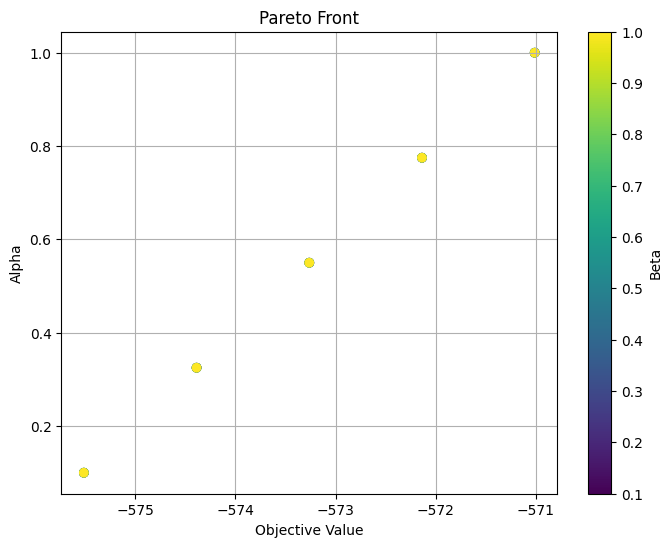

In [17]:
# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(objective_values, alpha_values, c=beta_values, cmap='viridis')
plt.xlabel('Objective Value')
plt.ylabel('Alpha')
plt.title('Pareto Front')
plt.colorbar(label='Beta')
plt.grid(True)
plt.show()

**Adding Tolerance**

To assess the tolerance level, we scaled down the data to smaller values to observe its response during the analysis. This exercise aims to illustrate the distinction between the scenarios before and after incorporating tolerance. The code effectively executes the analysis under these conditions.

In [18]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import numpy as np

# Sets and Indices
M = [1, 2, 3, 4, 5]  # Example list of countries below the poverty line
N = ['Truck', 'Ship', 'Airline']  # Example list of transportation modes

# Generate random parameters using NumPy arrays
FR = np.random.randint(1000, 5000, size=len(M))  # Annual food requirements for country i
DA = np.random.randint(5000, 20000, size=len(M))  # Annual donation to WFP for country i
PD = np.random.randint(1, 10, size=len(M))  # Preservation period for food in country i
SC = np.random.randint(20000, 100000, size=len(M))  # Storage capacity of the local hub for country i
MC = np.random.randint(50000, 200000, size=len(N))  # Maximum capacity for transportation mode j
#CT = {(i, j): {'Truck': 100, 'Ship': 200, 'Airline': 300}[j] for i in M for j in N}






# Additional data about countries
country_data = {
    'Burundi': {'Food Demand': 1400000, 'Road Network Extent (km)': 12232, 'Water Network Extent (km)': 673, 'Airports': 2},
    'Central African Republic': {'Food Demand': 2000000, 'Road Network Extent (km)': 23810, 'Water Network Extent (km)': 900, 'Airports': 3},
    'South Sudan': {'Food Demand': 7800000, 'Road Network Extent (km)': 90200, 'Water Network Extent (km)': 1400, 'Airports': 3},
    'Congo': {'Food Demand': 25800000, 'Road Network Extent (km)': 171250, 'Water Network Extent (km)': 16238, 'Airports': 60},
    'Somalia': {'Food Demand': 6600000, 'Road Network Extent (km)': 21830, 'Water Network Extent (km)': 3000, 'Airports': 62}
}


# Extracting the relevant data
food_demand = {country: country_data[country]['Food Demand'] for country in country_data}
road_network_extent = {country: country_data[country]['Road Network Extent (km)'] for country in country_data}
water_network_extent = {country: country_data[country]['Water Network Extent (km)'] for country in country_data}
airports = {country: country_data[country]['Airports'] for country in country_data}



# Create a new model
model = gp.Model("FoodAidDistribution")

# Decision Variables
Q = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, name=f"Q_{i}_{j}") for i in M for j in N}

# Generate random uncertain parameters using NumPy

#CT = {(i, j): np.random.uniform(0.01,0.1) for i in M for j in N}  # Nominal transportation cost per unit of food for country i using mode j
CT = {(1, 'Truck'): 0.06,
 (1, 'Ship'): 0.05,
 (1, 'Airline'): 0.039759361890725375,
 (2, 'Truck'): 0.08515762695235436,
 (2, 'Ship'): 0.04735379934764757,
 (2, 'Airline'): 0.051226090690935165,
 (3, 'Truck'): 0.07852344924238917,
 (3, 'Ship'): 0.06929878688701206,
 (3, 'Airline'): 0.03712843900107501,
 (4, 'Truck'): 0.072,
 (4, 'Ship'): 0.065,
 (4, 'Airline'): 0.077,
 (5, 'Truck'): 0.058,
 (5, 'Ship'): 0.065,
 (5, 'Airline'): 0.079}


TT = {(i, j): np.random.uniform(.5, 2) for i in M for j in N}  # Nominal transportation time for country i using mode j



# Constraints
PC = random.randint(500000, 1000000)  # Random budget constraint value

model.addConstr(gp.quicksum(CT[i, j] * Q[i, j] for i in M for j in N) <= PC, name="Budget_Constraint")

for i in M:
    for j in N:
        model.addConstr(Q[i, j] <= DA[i - 1] * PD[i - 1], name=f"Preservation_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= FR[i - 1], name=f"Demand_Constraint_{i}_{j}")
        model.addConstr(Q[i, j] <= SC[i - 1], name=f"Storage_Capacity_Constraint_{i}_{j}")

# Transportation Capacity Constraint

constraints = {
    1: {'Truck': 2000, 'Ship': 5000, 'Airline': 500},
    2: {'Truck': 1000, 'Ship': 4000, 'Airline': 250},
    3: {'Truck': 3000, 'Ship': 6000, 'Airline': 1000},
    4: {'Truck': 4000, 'Ship': 5000, 'Airline': 700},
    5: {'Truck': 5000, 'Ship': 6000, 'Airline': 800}
}

# Create constraints for each country and transportation mode within a loop
for country in M:
    for mode in N:
        quantity = constraints[country][mode]
        model.addConstr(Q[country, mode] <= quantity, name=f"{mode}_Quantity_Constraint_Country{country}")



# Non-Negativity Constraint
for i in M:
    for j in N:
        model.addConstr(Q[i, j] >= 0, name=f"Non_Negativity_Constraint_{i}_{j}")

# Food Supply Constraint for Each Country
for i in M:
    model.addConstr(gp.quicksum(Q[i, j] for j in N) >= 1, name=f"Food_Supply_Constraint_{i}")

# Constraint to ensure each transportation mode is used
for j in N:
    model.addConstr(gp.quicksum(Q[i, j] for i in M) >= 1, name=f"Transportation_Mode_Usage_Constraint_{j}")






distances = {(1, 'Truck'): 500, (1, 'Ship'): 200, (1, 'Airline'): 100,
             (2, 'Truck'): 100, (2, 'Ship'): 150, (2, 'Airline'): 200,
             (3, 'Truck'): 800, (3, 'Ship'): 180, (3, 'Airline'): 150,
             (4, 'Truck'): 800, (4, 'Ship'): 180, (4, 'Airline'): 150,
             (5, 'Truck'): 800, (5, 'Ship'): 180, (5, 'Airline'): 150}


# Actual data for weather conditions and transportation medium conditions affecting cost and time
weather_cost_multiplier = {'Winter': 0.2, 'Summer': 0.0, 'Rainy Season': 0.1}
weather_time_multiplier = {'Winter': 0.3, 'Summer': 0.0, 'Rainy Season': 0.15}

transportation_medium_cost_multiplier = {'Excellent': 0.0, 'Moderate': 0.15, 'Poor': 0.3}
transportation_medium_time_multiplier = {'Excellent': 0.0, 'Moderate': 0.1, 'Poor': 0.25}

# Define the weight factors
alpha = 1
beta = 1
gamma = 1
delta = 1

# Objective Function without Tolerance
model.setObjective(
    alpha * gp.quicksum(Q[i, j] for i in M for j in N) -
    beta * gp.quicksum((weather_cost_multiplier[weather_condition]
                        + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                       for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
    gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                         + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                        for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
    delta * gp.quicksum(distances[i, j] * Q[i, j] for i in M for j in N),
    sense=GRB.MAXIMIZE
)

# Optimize the model without tolerance
model.optimize()
objective_value_without_tolerance = model.objVal

# Define a list for tolerance values
tolerance_values = [0.0, 0.1, 0.2, 0.3, 0.4]  # Modify this as needed

# Lists to store objective values
objective_values_with_tolerance = []

# Iterate through tolerance values
for tolerance in tolerance_values:
    # Objective Function with Tolerance
    model.setObjective(
        alpha * gp.quicksum(Q[i, j] for i in M for j in N) -
        beta * gp.quicksum((weather_cost_multiplier[weather_condition]
                            + transportation_medium_cost_multiplier[transport_condition]) * CT[i, j] * Q[i, j]
                           for i in M for j in N for weather_condition in weather_cost_multiplier for transport_condition in transportation_medium_cost_multiplier) -
        gamma * gp.quicksum((weather_time_multiplier[weather_condition]
                             + transportation_medium_time_multiplier[transport_condition]) * TT[i, j] * Q[i, j]
                            for i in M for j in N for weather_condition in weather_time_multiplier for transport_condition in transportation_medium_time_multiplier) -
        delta * gp.quicksum(distances[i, j] * Q[i, j] * (1 + tolerance) for i in M for j in N),
        sense=GRB.MAXIMIZE
    )

    # Optimize the model with tolerance
    model.optimize()
    objective_values_with_tolerance.append(model.objVal)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 84 rows, 15 columns and 120 nonzeros
Model fingerprint: 0x0837f4fb
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [1e+02, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 76 rows and 0 columns
Presolve time: 0.01s
Presolved: 8 rows, 15 columns, 30 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   1.000000e+00   0.000000e+00      0s
       6   -6.8923688e+02   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective -6.892368780e+02
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Th

**Visualization of Tolerance**

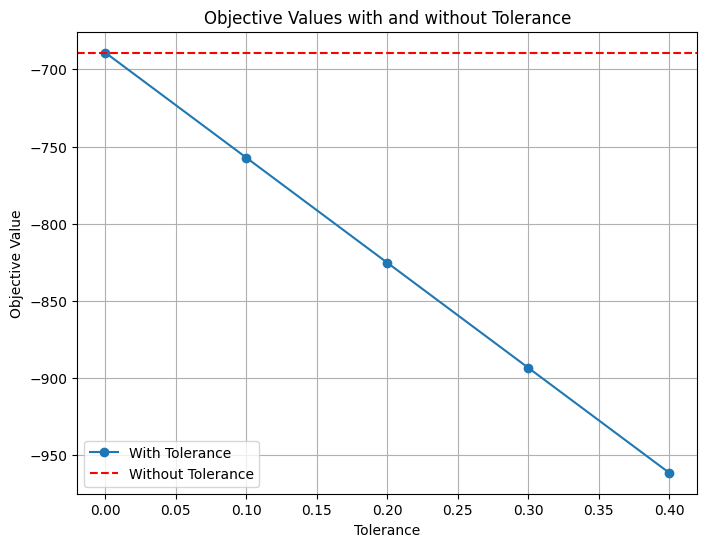

In [19]:
# Plotting objective values with and without tolerance
plt.figure(figsize=(8, 6))
plt.plot(tolerance_values, objective_values_with_tolerance, marker='o', label='With Tolerance')
plt.axhline(y=objective_value_without_tolerance, color='r', linestyle='--', label='Without Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Objective Value')
plt.title('Objective Values with and without Tolerance')
plt.legend()
plt.grid(True)
plt.show()